<b><font color='darkred'>
FFNN - Feed Forward Neural Network
-----------------
➔ Verwenden statistischer Größen der Zeitreihen als Features<br><br><br>





Bisherige Ergebnisse:</b>  

<u>Mit PCA & synthetischen Daten: </u>                 
Beste Hyperparameter: {'neurons_1': 81, 'neurons_2': 43, 'learning_rate': 0.0012} # MAE=87  
Beste Hyperparameter: {'neurons_1': 94, 'neurons_2': 17, 'learning_rate': 0.0408}                # MAE=89   
Beste Hyperparameter: {'neurons_1': 162, 'neurons_2': 32, 'learning_rate': 0.0052} # MAE=85 (Nur neue Trainingsdaten)

<u>Mit PCA ohne synthetischen Daten: </u>  
Beste Hyperparameter: {'neurons_1': 234, 'neurons_2': 80, 'learning_rate': 0.0044} #MAE=94

<u>Mit PCA ohne synthetischen Daten: </u>        
Beste Hyperparameter: {'neurons_1': 69, 'neurons_2': 23, 'learning_rate': 0.0172} # MAE=97

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
import keras_tuner as kt
from tensorflow import keras
import helper

/Users/melanie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# PCA Anwendung?
pca = False      
n_components = 0.98

# Neue zusätzliche synthetische Daten erzeugen?
synthetic_data = False 

# Skalierung für Zielvariable Zugfestigkeit
SCALE = 2000    

# Statistische Kennzahlen für die Modellerstellung
STATS = [
    # Power (p_*)
    "p_median", "p_std", "p_max", "p_q25", "p_q75", 
    "p_iqr_range", "p_f_ratio", "p_d_ratio", "p_t_ratio",
    #"p_mean", 
    
    # Force (f_*)
    "f_median", "f_std", "f_max", "f_q25", "f_q75", 
    "f_iqr_range", "f_d_ratio", "f_t_ratio",
    #"f_mean", 

    # Distance (d_*)
    "d_median", "d_std", "d_max", "d_q25", "d_q75", 
    "d_iqr_range", "d_t_ratio", #"d_b75",
    #"d_mean",  

    # Zeitmerkmale
    "t_max",
]

# 🏆
STATS = ['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25', 'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio', 't_max', 'p_std', 'd_std']

In [5]:
zugversuche, kurven, versuche_train, versuche_test = helper.read_data()

In [6]:
stat_feat = helper.StatFeatures(STATS)
stat_feat.fit()

StatFeatures(columns=['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25',
                      'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio',
                      't_max', 'p_std', 'd_std'])

In [7]:
X_train = stat_feat.transform(versuche_train.key, kurven)
X_test  = stat_feat.transform(versuche_test.key,  kurven)

print(X_train.shape, X_test.shape) 

(480, 12) (120, 12)


In [8]:
label_train      = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values

label_test      = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values

print(festigkeit_train.shape, festigkeit_test.shape) 

(480,) (120,)


<b><font color='lightgreen'> Skalierung (Normierung) der Trainings- & Testdaten 

In [9]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled  = std_scaler.transform(X_test)

festigkeit_test  = festigkeit_test/SCALE
festigkeit_train = festigkeit_train/SCALE

<b><font color='lightgreen'> Erzeugung zusätzlicher synthetischer Daten - Jittering & Gaussian Noise

In [10]:
def add_jitter(X, y_label, y_festigkeit, noise_level=0.05, num_augmentations=3):
    """
    Fügt Jittering (Gaussian Noise) zu den Eingabedaten und der Zugfestigkeit hinzu.

    Parameters:
        X (numpy array): Die ursprünglichen Merkmale.
        y_label (numpy array): Die Klassenzuordnung (Labels).
        y_festigkeit (numpy array): Die Zugfestigkeit.
        noise_level (float): Standardabweichung des Gaussian Noise relativ zur Feature-Standardabweichung.
        num_augmentations (int): Anzahl der neuen synthetischen Datenpunkte pro Originalprobe.

    Returns:
        X_aug (numpy array): Erweitertes Feature-Set mit Jittering.
        y_label_aug (numpy array): Erweitertes Label-Set.
        y_festigkeit_aug (numpy array): Erweitertes Zugfestigkeits-Set.
    """
    X_aug, y_label_aug, y_festigkeit_aug = [], [], []

    for i in range(len(X)):
        for _ in range(num_augmentations):
            # Gaussian Noise für Features - Standardabweichung
            noise_X = np.random.normal(loc=0, scale=noise_level * np.std(X, axis=0), size=X.shape[1])
            X_aug.append(X[i] + noise_X)

            # Gaussian Noise für Zugfestigkeit (keine Werte kleiner 0 möglich) - Mean
            noise_y = np.random.normal(loc=0, scale=noise_level-0.02 * np.mean(y_festigkeit))
            new_strength = max(0, y_festigkeit[i] + noise_y)
            y_festigkeit_aug.append(new_strength)

            y_label_aug.append(y_label[i])
            #y_festigkeit_aug.append(y_festigkeit[i])

    # Originale Daten anhängen
    X_aug = np.vstack([X, np.array(X_aug)])
    y_label_aug = np.hstack([y_label, np.array(y_label_aug)])
    y_festigkeit_aug = np.hstack([y_festigkeit, np.array(y_festigkeit_aug)])

    return X_aug, y_label_aug, y_festigkeit_aug

In [11]:
if synthetic_data == True:
    # Jittering auf Trainingsdaten anwenden
    X_train_aug, label_train_aug, festigkeit_train_aug = add_jitter(X_train_scaled, label_train, festigkeit_train)

    # Ausgaben
    print(f"Alte Trainingsdaten:      {X_train.shape}, Labeldaten: {label_train.shape}")
    print(f"Mit neuen Trainingsdaten: {X_train_aug.shape}, Mit neuen Labeldaten: {label_train_aug.shape}")
        
    
    plt.hist(festigkeit_train_aug*SCALE, bins=50, alpha=0.8, label="Jittered y", color="darkorange")
    plt.hist(festigkeit_train*SCALE,     bins=50, alpha=1,   label="Original y", color="darkblue")
    plt.title("Compare Zugfestigkeit data", weight='bold')
    plt.legend()
    plt.show()

    plt.hist(label_train_aug, bins=10, alpha=0.8, label="Jittered label", color="darkorange")
    plt.hist(label_train,     bins=10, alpha=1,   label="Original label", color="darkblue")
    plt.title("Compare label data", weight='bold')
    plt.xticks(np.arange(0,5,1))
    plt.legend()
    plt.show()

    X_train_scaled   = X_train_aug
    festigkeit_train = festigkeit_train_aug
    label_train      = label_train_aug

<b><font color='lightgreen'> Dimensionsreduktion - PCA (Principal Component Analysis) 

In [12]:
if pca == True:
    pca_scaler = PCA(n_components=n_components)
    X_train_scaled = pca_scaler.fit_transform(X_train_scaled)
    X_test_scaled  = pca_scaler.transform(X_test_scaled)
    print(pca_scaler.n_components_, pca_scaler.explained_variance_ratio_)

In [13]:
print(festigkeit_train.shape, X_train_scaled.shape, label_train.shape)

(480,) (480, 12) (480,)


In [14]:
print(festigkeit_test.shape, X_test_scaled.shape, label_test.shape) 

(120,) (120, 12) (120,)


<b><font color='lightgreen'> Kontrollanzeige t-SNE

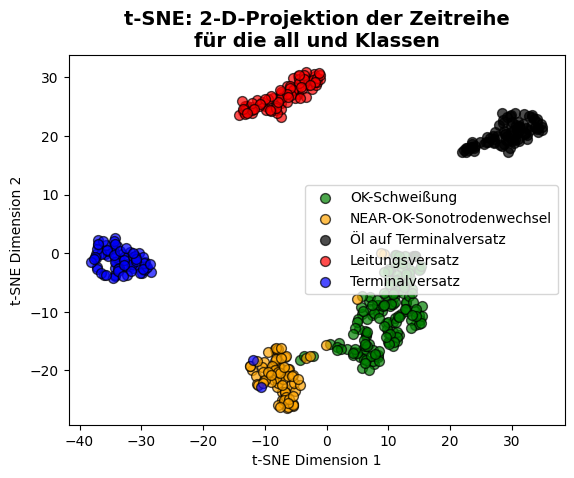

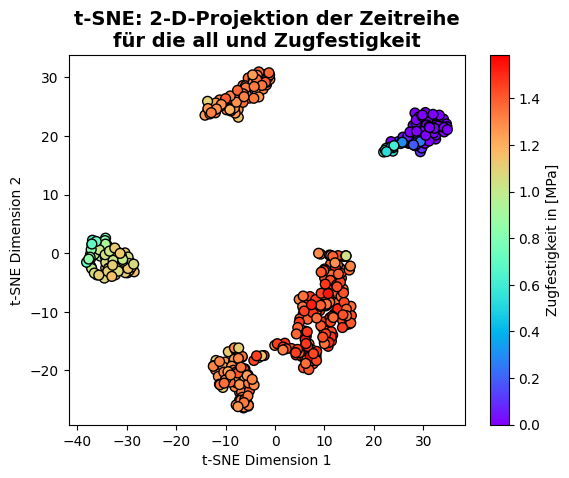

In [15]:
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Klassen')
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Zugfestigkeit')

<b><font color='lightgreen'><h3> FFN für Klassifikation (Hyperparametersuche - Random Search)

In [16]:
# Modell mit Hyperparameter-Optimierung definieren
def build_tuned_model(hp):
    model = keras.Sequential([
        keras.layers.Dense(hp.Int('neurons_1', min_value=32, max_value=128), activation="relu", # , step=32
                     input_shape=(X_train_scaled.shape[1],)),
        keras.layers.Dense(hp.Int('neurons_2', min_value=16, max_value=64), activation="relu"), # , step=16
        keras.layers.Dense(5, activation="softmax")  # 5 Klassen
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', list(np.arange(0,0.1,0.0001)))),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

# Keras Tuner für Random Search
tuner = kt.RandomSearch(
    build_tuned_model,
    objective="val_accuracy",
    max_trials=10,  # 10 verschiedene Modelle testen
    seed=42,
    executions_per_trial=1,
    overwrite=True,
    directory="Modelle/ffn",
    project_name="ffn_classification"
)

# Suche starten
tuner.search(X_train_scaled, label_train, epochs=50, validation_data=(X_test_scaled, label_test), verbose=2)

# Bestes Modell auswählen
best_model = tuner.get_best_models(num_models=1)[0]
best_hps   = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Beste Hyperparameter:", best_hps.values)

best_model.fit(X_train_scaled, label_train, epochs=100, validation_data=(X_test_scaled, label_test))

Trial 10 Complete [00h 00m 01s]

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 13s


Beste Hyperparameter: {'neurons_1': 94, 'neurons_2': 17, 'learning_rate': 0.0408}
Epoch 1/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0542 - accuracy: 0.9792 - val_loss: 0.0864 - val_accuracy: 0.9750
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0575 - accuracy: 0.9854 - val_loss: 0.0374 - val_accuracy: 0.9833
Epoch 3/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0364 - accuracy: 0.9896 - val_loss: 0.0548 - val_accuracy: 0.9917
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0531 - accuracy: 0.9812 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0499 - accuracy: 0.9833 - val_loss: 0.0350 - val_accuracy: 0.9917
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0808 - accuracy: 0.9792 - val_loss: 0.0410 - val_accuracy: 0.9917
Epoch 7/100
15/15 [==============================] - 0s 1ms/step - loss:

4/4 [==============================] - 0s 858us/step


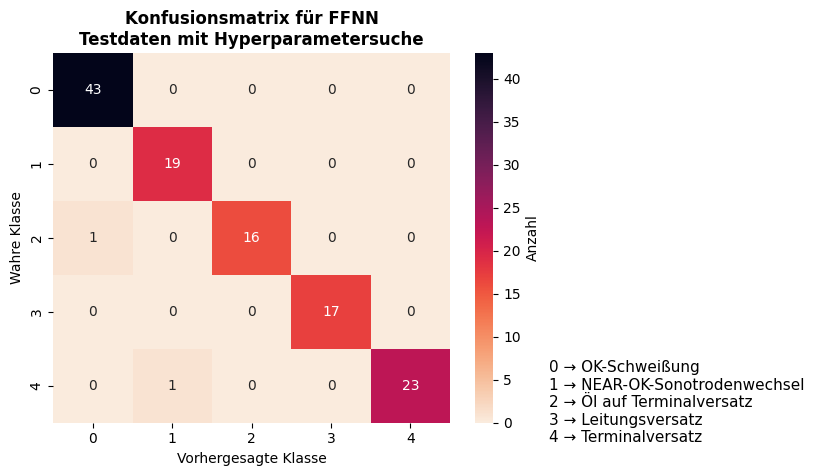

In [17]:
# Vorhersagen erhalten
pred_train = best_model.predict(X_train_scaled).argmax(axis=1)
pred_test  = best_model.predict(X_test_scaled).argmax(axis=1)

helper.plot_confusion(label_test, pred_test, 'FFNN\nTestdaten mit Hyperparametersuche')

In [18]:
score_train = best_model.evaluate(X_train_scaled, label_train)
score_test  = best_model.evaluate(X_test_scaled,  label_test)
score = pd.DataFrame({ 'Metric': ['Loss', 'Accuracy'], 'Train': score_train, 'Test': score_test}).set_index('Metric').round(3)
sc = score.reset_index()
sc = sc[sc.Metric == 'Loss'].set_index('Metric')

val = helper.get_metric_table_class(label_train, pred_train, label_test, pred_test)
val = pd.concat([val, sc])
val

4/4 [==============================] - 0s 991us/step - loss: 0.0531 - accuracy: 0.9833
                        precision    recall  f1-score   support

                    ok      0.977     1.000     0.989        43
   near_ok_sonowechsel      0.950     1.000     0.974        19
            fehler_oel      1.000     0.941     0.970        17
fehler_leitungsversatz      1.000     1.000     1.000        17
  fehler_terminversatz      1.000     0.958     0.979        24

              accuracy                          0.983       120
             macro avg      0.985     0.980     0.982       120
          weighted avg      0.984     0.983     0.983       120



,Train,Test
Metric,,
Accuracy,0.981,0.983
Precision,0.982,0.984
Recall,0.981,0.983
F1-score,0.981,0.983
Loss,0.063,0.053


<b><font color='lightgreen'><h3> FFN für Regression (Hyperparametersuche - Random Search)

In [19]:
def build_tuned_regression_model(hp):
    """ Funktion, die verschiedene Hyperparameter testet """
    model = keras.Sequential([
        keras.layers.Dense(hp.Int('neurons_1', min_value=32, max_value=256), activation="relu",  #, step=32
                     input_shape=(X_train_scaled.shape[1],)),
        keras.layers.Dense(hp.Int('neurons_2', min_value=16, max_value=128), activation="relu"), #, step=16
        keras.layers.Dense(1)  # Regression: 1 Neuron, kein Softmax/Sigmoid
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', list(np.arange(0,0.1,0.0001)))),
                  loss="mse",       # Mean Squared Error für Regression
                  metrics=["mae"])  # Mean Absolute Error als zusätzliche Metrik
    
    return model

In [20]:
# Keras Tuner für Hyperparameter-Suche einrichten
tuner = kt.RandomSearch(
    build_tuned_regression_model,
    objective="val_mae",  # Ziel: Geringste Mean Absolute Error (MAE)
    max_trials=20,        # 10 verschiedene Modellkonfigurationen testen
    executions_per_trial=1,  
    overwrite=True,
    directory="Modelle/ffn",
    project_name="ffn_regression"
)

# Hyperparametersuche starten
tuner.search(X_train_scaled, 
             festigkeit_train, 
             epochs=50, 
             validation_data=(X_test_scaled, festigkeit_test), 
             verbose=2)

# Bestes Modell auswählen
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Beste Hyperparameter:", best_hps.values)

Trial 20 Complete [00h 00m 02s]
val_mae: 0.04372123256325722

Best val_mae So Far: 0.04018378257751465
Total elapsed time: 00h 00m 35s
Beste Hyperparameter: {'neurons_1': 87, 'neurons_2': 71, 'learning_rate': 0.0112}


In [21]:
# Bestes Modell neu erstellen und trainieren
best_model = tuner.hypermodel.build(best_hps)
hist = best_model.fit(X_train_scaled, festigkeit_train, epochs=100, 
               validation_data=(X_test_scaled, festigkeit_test))

# Vorhersagen mit dem besten Modell
pred_train = best_model.predict(X_train_scaled).flatten()
pred_test  = best_model.predict(X_test_scaled).flatten()

Epoch 1/100
15/15 [==============================] - 0s 5ms/step - loss: 0.3488 - mae: 0.4371 - val_loss: 0.0488 - val_mae: 0.1881
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0472 - mae: 0.1717 - val_loss: 0.0245 - val_mae: 0.1222
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0182 - mae: 0.1038 - val_loss: 0.0126 - val_mae: 0.0832
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0078 - mae: 0.0685 - val_loss: 0.0086 - val_mae: 0.0718
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0081 - mae: 0.0706 - val_loss: 0.0062 - val_mae: 0.0560
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0067 - mae: 0.0640 - val_loss: 0.0067 - val_mae: 0.0608
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0068 - mae: 0.0646 - val_loss: 0.0055 - val_mae: 0.0551
Epoch 8/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0070 - m

<b><font color='lightgreen'> Modellbewertung</b>

In [22]:
helper.get_metric_table_regr(festigkeit_train, pred_train, festigkeit_test, pred_test, SCALE)

,Train,Test
Metric,,
MSE,15826.85,15568.93
RMSE,125.80,124.78
MAE,97.30,95.41
R²,0.98,0.98


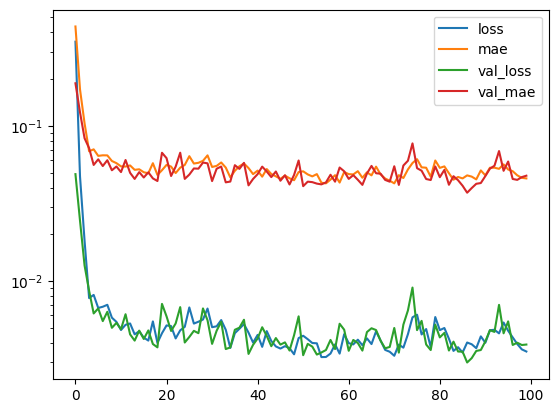

In [23]:
pd.DataFrame(hist.history).plot(logy=True)
plt.show()

<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

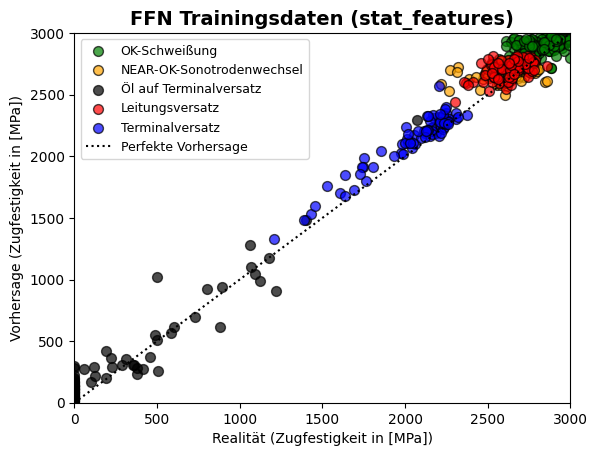

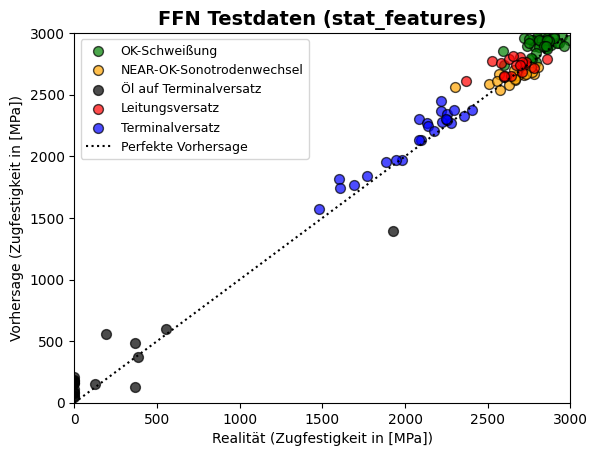

In [24]:
helper.plot_pred(pred_train, festigkeit_train, label_train, 'FFN Trainingsdaten (stat_features)', 'mit Linie', SCALE)
helper.plot_pred(pred_test, festigkeit_test, label_test, 'FFN Testdaten (stat_features)', 'mit Linie', SCALE)